In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None 

## Task 1

(15 points) In this exercise, you will perform tasks faced by a data analyst working for a supermarket
chain (’supermarket.csv’, when importing the file, use sep=’;’). Your job is to build a predictive model to
estimate the purchase amount (’Total’ column) for a customer. You have the following information:
• Branch: branch of the supermarket chain, there is data about three different branches (A, B, and C)
• Customer type: indicating whether the customer is a Member of the loyalty program or not
• Gender: the gender of the customer
• Quantity: number of products purchased by the customer
• Total: amount of purchase
• Payment: payment type used by the customer
• Income: income of the customer
• Rating: rating given by the customer to the store

In [52]:
## reading the data and quickly checking

superma = pd.read_csv('Datasets/supermarket.csv', sep=';')
superma.head(10)

,Branch,Customer type,Gender,Quantity,Total,Payment,Income,Rating
0,A,Member,Female,7,548.9715,Ewallet,26.1415,9.1
1,C,Normal,Female,5,80.2200,Cash,3.8200,9.6
2,A,Normal,Male,7,340.5255,Credit card,16.2155,7.4
3,A,Member,Male,8,489.0480,Ewallet,23.2880,8.4
4,A,Normal,Male,7,634.3785,Ewallet,30.2085,5.3
5,C,Normal,Male,7,627.6165,Ewallet,29.8865,4.1
6,A,Member,Female,6,433.6920,Ewallet,20.6520,5.8
7,C,Normal,Female,10,772.3800,Ewallet,36.7800,8.0
8,A,Member,Female,2,76.1460,Credit card,3.6260,7.2
9,B,Member,Female,3,172.7460,Credit card,8.2260,5.9


In [53]:
superma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Branch         1000 non-null   object 
 1   Customer type  1000 non-null   object 
 2   Gender         1000 non-null   object 
 3   Quantity       1000 non-null   int64  
 4   Total          1000 non-null   float64
 5   Payment        1000 non-null   object 
 6   Income         1000 non-null   float64
 7   Rating         1000 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 62.6+ KB


Exploratory data analysis: try to understand the different variables in the data. As part of this
exploratory analysis, create visualizations that show the relationship between ’Total’ and the other
variables (create at least 4 plots, you are free to create more if you think it can help in understating
the problem), perform aggregation (check how average ’Total’ varies across categorical variables).

In [ ]:
#understanding data. This is a very stange dataset.
#Seems Quantity of Items does not follow a Normal distribution similarly with Rating.
#The mostc common quatity is 5, which is also the mean.
#The average rating in 7.5 but the most common is around 6.

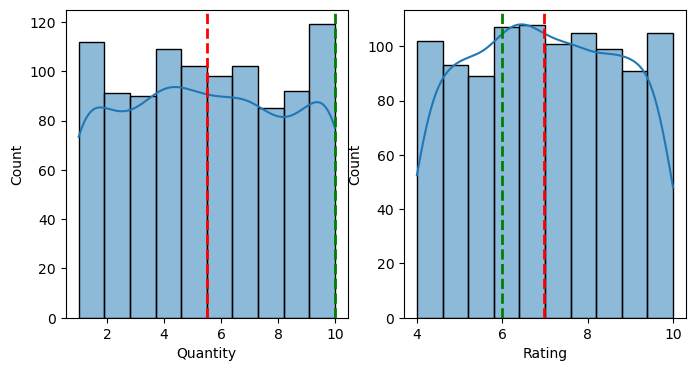

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=superma, x='Quantity', bins=10, kde=True, ax=ax[0])
ax[0].axvline(superma['Quantity'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[0].axvline(superma['Quantity'].mode()[0], color='g', linestyle='dashed', linewidth=2)

sns.histplot(data=superma, x='Rating', bins=10, kde=True, ax=ax[1])
ax[1].axvline(superma['Rating'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[1].axvline(superma['Rating'].mode()[0], color='g', linestyle='dashed', linewidth=2)

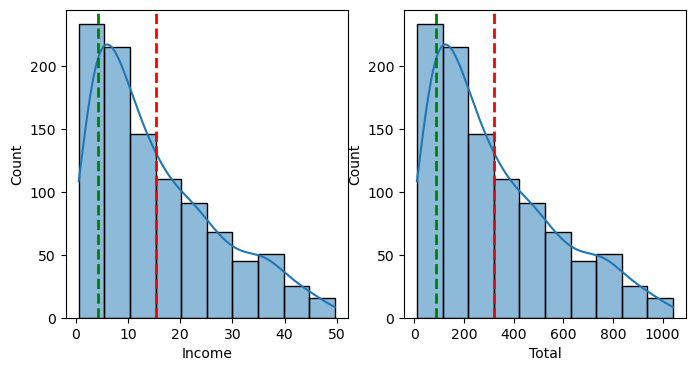

In [55]:
#the Income and Total purchases are basically identical. They do not group around the mean,
#they do not follow a normal distribution, but the most common values are lower incomes and lower
#total purchases
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=superma, x='Income', bins=10, kde=True, ax=ax[0])
ax[0].axvline(superma['Income'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[0].axvline(superma['Income'].mode()[0], color='g', linestyle='dashed', linewidth=2)

sns.histplot(data=superma, x='Total', bins=10, kde=True, ax=ax[1])
ax[1].axvline(superma['Total'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[1].axvline(superma['Total'].mode()[0], color='g', linestyle='dashed', linewidth=2)

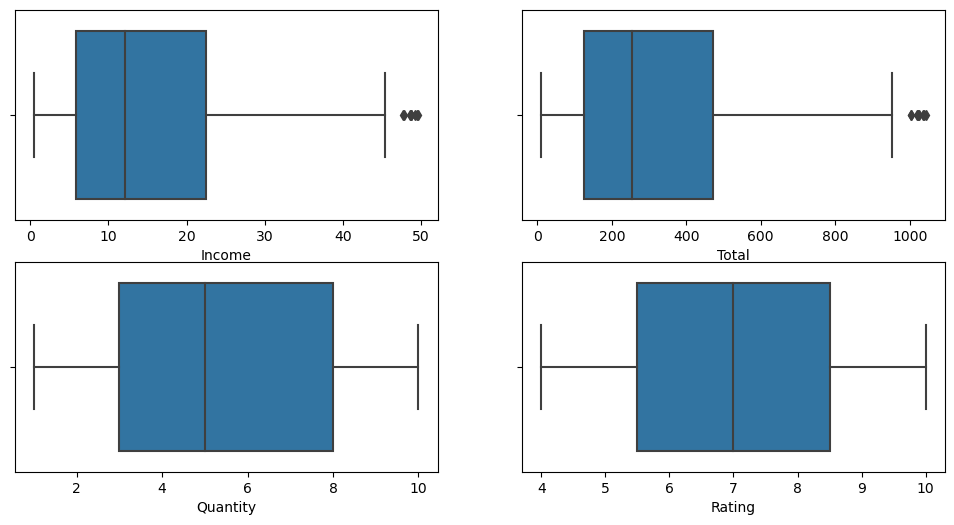

In [56]:
#checking for outliers. Seems I will have to clean Income and Total

fig, axs = plt.subplots(ncols=2, nrows =2, figsize=(12, 6))

sns.boxplot(x='Income',data=superma, ax=axs[0,0])
sns.boxplot(x='Total', data=superma, ax=axs[0,1])
sns.boxplot(x='Quantity', data=superma,ax=axs[1,0])
sns.boxplot(x='Rating', data=superma, ax=axs[1,1])

plt.show()

In [57]:
# Remove outliers: for each numeric column, remove the top 5% of values (0.95 quantile)

toclean = ['Income', 'Total']

for i in toclean:
    cut_off = superma[i].quantile(0.95)
    superma_c = superma[superma[i] < cut_off]
    
superma_c.shape

(950, 8)

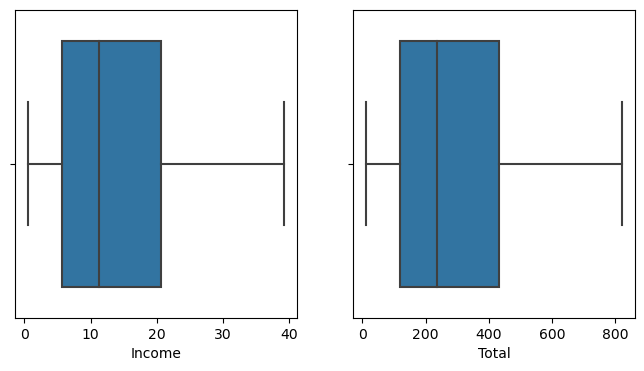

In [58]:
#cleaned!

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.boxplot(x='Income',data=superma_c, ax=axs[0])
sns.boxplot(x='Total', data=superma_c, ax=axs[1])

plt.show()

            Income     Total    Rating  Quantity
Income    1.000000  1.000000 -0.032111  0.673826
Total     1.000000  1.000000 -0.032111  0.673826
Rating   -0.032111 -0.032111  1.000000 -0.010512
Quantity  0.673826  0.673826 -0.010512  1.000000


<AxesSubplot:>

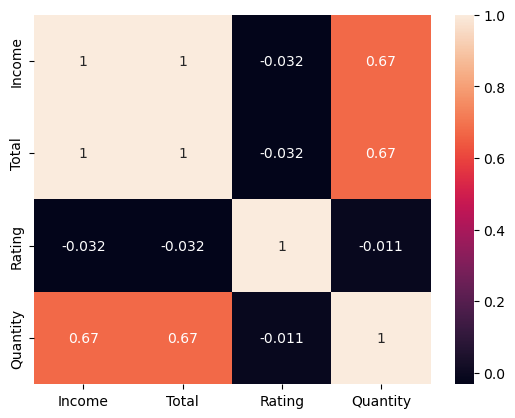

In [59]:
#let's move on with a Heatmap about the correlation between numerical variables
# Since we are interested in the Total Purhase we can check with what it correlates the most
#Also, we can spot possible correlation between predictors and remove them to avoid
#Multicollinearity in our regression model later on

numerical = superma_c[['Income','Total','Rating','Quantity']]

correlation = numerical.corr()
print(correlation)
sns.heatmap(correlation, annot = True)

## there is perfect correlation between Total Purchase and Income
## the other variable that seems to have a moderate relationship with Total Purchase is Quantity,
#I would have expected a higher correlation between Total and Rating, an especially a POSITIVe one
#no multicollinearity, since the other variables have very low corr coefficients

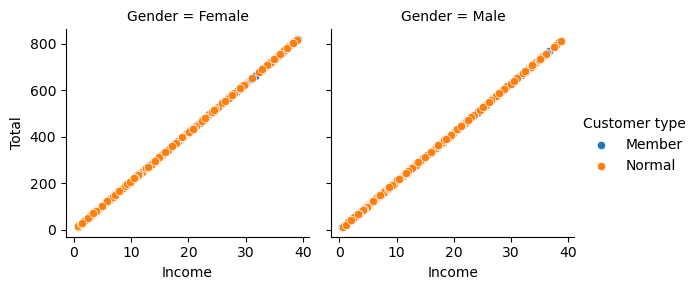

In [60]:
#using FactGrid() to add simultaneously some other categorical variables in the scatterplot
#it confirms perfect relationship between income and total purchase

g = sns.FacetGrid(superma_c, col="Gender", hue="Customer type")
g.map(sns.scatterplot, "Income", "Total")
g.add_legend()

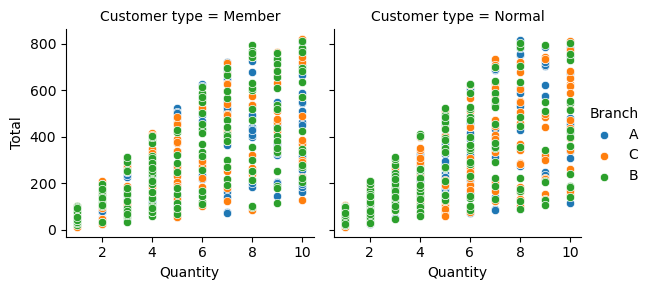

In [61]:
#and this is how the correlation between Total and Quantity looks like.
#No diffeernce based on the membership type, even if it seems that the stores Branches
#maybe the branch B has higher amount of purchases?

g = sns.FacetGrid(superma_c, col="Customer type", hue="Branch")
g.map(sns.scatterplot, "Quantity", "Total")
g.add_legend()

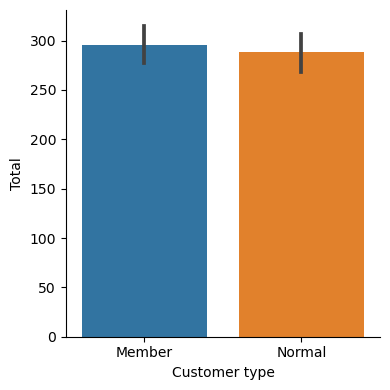

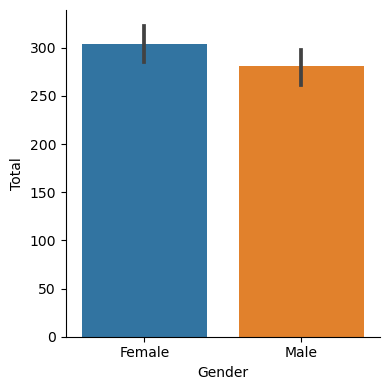

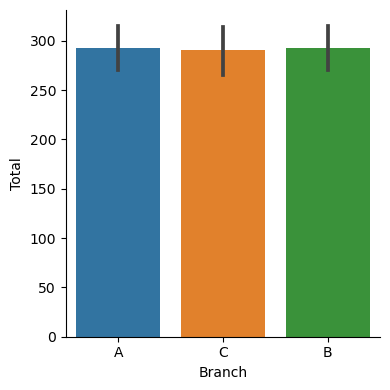

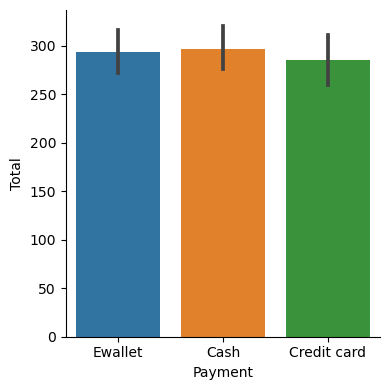

In [62]:
#generating one bar plot per categorical variable, to display how the mean of Total purchase
#behaves across them.
#I honestly do not see any categorical variable impacting sigificantly teh mean, maybe the Gender
#and customer type: Females have slightly higher mean of total purchases, same with Member customers
categorical=superma_c[['Customer type','Gender', 'Branch', 'Payment']]

for var in categorical:
    sns.catplot(data=superma_c, y='Total',x=var,kind='bar',estimator=np.mean, height=4, aspect=1)
plt.show()

Divide the data into training and test set: the training set should contain datapoints from branches
A and B, and the test set from branch C. Develop a regression model using the training set that the
company can use to predict the amount of purchase for a customer. Evaluate the performance for
the test set.

In [63]:
#converting Gender and Customer Type from Categorical to Numerical
superma_c['IsFemale'] = (superma_c['Gender'] == 'Female').astype(int)
superma_c['IsMember'] = (superma_c['Customer type'] == 'Member').astype(int)

#creating the DF for the prediction model
pred_data = superma_c[['Income', 'Quantity', 'IsFemale', 'IsMember', 'Total', 'Branch']]
pred_data.head()

,Income,Quantity,IsFemale,IsMember,Total,Branch
0,26.1415,7,1,1,548.9715,A
1,3.8200,5,1,0,80.2200,C
2,16.2155,7,0,0,340.5255,A
3,23.2880,8,0,1,489.0480,A
4,30.2085,7,0,0,634.3785,A


In [64]:
#creating training and test sets

X_train1 = pred_data[['Income', 'Quantity','IsFemale', 'IsMember']][pred_data['Branch'].isin(['A','B'])]
X_test1 = pred_data[['Income', 'Quantity','IsFemale', 'IsMember']].loc[pred_data['Branch']=='C']

#target variable shall be a Series
y_train1 = pred_data[['Total']][pred_data['Branch'].isin(['A','B'])].squeeze()
y_test1 = pred_data[['Total']].loc[pred_data['Branch']=='C'].squeeze()



In [65]:
#using the stastmodel library for printing the summary containing also the test statistics results
#Coefficient of Determination is 1, meaning that the model (the resulting coefficients)
#explains perfectly the relationships between predictors and response variable.
#Also the F-statistic tells that there is at least one predictor coefficient that is not 0
#the P values of the T statistic are also low enough to suggest that most coefficients
#are meaningful in predicting the 'Total'.
#We can maybe remove Quantity and try to recalculate, however since we already have 1 as coefficient
#of determination, even removing Quantity will not improve (we already have the highest)

X2 = sm.add_constant(X_train1)
est_b = sm.OLS(y_train1, X2)
est2_b = est_b.fit()

print(est2_b.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.961e+31
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:53:48   Log-Likelihood:                 17491.
No. Observations:                 646   AIC:                        -3.497e+04
Df Residuals:                     641   BIC:                        -3.495e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.736e-13   4.08e-14      6.710      0.0

In [66]:
#using now the sklearn library and LinearRegression() to make a prediction

# Train the model using the predictor and target data
regr1 = linear_model.LinearRegression()
model1 = regr1.fit(X_train1, y_train1)

#Now I am trying to make a prediction for the y variable
#using the model we just built, and the X values from the test set
y_pred1 = regr1.predict(X_test1)

#comparing how different the predictions are from the Y in the test set
print(y_pred1[:5])
print(y_test1[:5])

#as expected, we can predict exactly the values of Y using the coefficients calculated in the model.
#But what I can say, in accordance with the principle of parsimony for good regression models, is
#that it is kinda self evident that the variable Income explains already basically all the relationship
#(or variation) in the response variable "Total". So honestly I do not see really the need to
#include all the others. In simpler words, we already have a perfect regression line just by using
#Income. Throwing in other observation ("points" ) from other variables, will just
#mess up the things and complicate the calculation of a better fitting line. Because we already have
#the best fitting line.


[ 80.22   627.6165 772.38   451.71   417.564 ]
1      80.2200
5     627.6165
7     772.3800
20    451.7100
34    417.5640
Name: Total, dtype: float64


In [67]:
#Now I am creating a new model with just only teh variable i think is sufficient to predict teh Total
#and see what will happen

#creating training and test sets

X_train2 = pred_data[['Income']][pred_data['Branch'].isin(['A','B'])]
X_test2 = pred_data[['Income']].loc[pred_data['Branch']=='C']

#target variable shall be a Series
y_train2 = pred_data[['Total']][pred_data['Branch'].isin(['A','B'])].squeeze()
y_test2 = pred_data[['Total']].loc[pred_data['Branch']=='C'].squeeze()

In [68]:
X2 = sm.add_constant(X_train2)
est_b = sm.OLS(y_train2, X2)
est2_b = est_b.fit()

print(est2_b.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.229e+33
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:58:42   Log-Likelihood:                 18151.
No. Observations:                 646   AIC:                        -3.630e+04
Df Residuals:                     644   BIC:                        -3.629e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.474e-13   1.03e-14     14.360      0.0

In [69]:
#this simpler model is equally good enough

regr2 = linear_model.LinearRegression()
model2 = regr2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)

print(y_test2[:5])
print(y_pred2[:5])

1      80.2200
5     627.6165
7     772.3800
20    451.7100
34    417.5640
Name: Total, dtype: float64
[ 80.22   627.6165 772.38   451.71   417.564 ]


By looking at the coefficients of your final model, would you say that, in general, (i) male or female
customers spend more money in the supermarket; (ii) members of the loyalty program or normal
customers spend more money?

In [ ]:
Isfemale -9.948e-14
IsMember -6.04e-14

#The negative coefficients indicate that these variables impact negatively the variable Total:
#at the increasing of variable X, Y decreases.
#when the value of the variable is 1 (Being Female or being a Member) the result of Y will be
#reduced by the amounts indicated in the related coefficients.

## Task 2

15 points) In this assignment, your task is to create a classification model that can predict whether a
reservation in a hotel will be canceled or not. The data is in the file ’hotel.csv’ (when importing, use sep = ’;’)

In [34]:
hotel = pd.read_csv("Datasets/hotel.csv", sep=';')
hotel.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,0,Room_Type 1,224,10,2,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,0,Room_Type 1,5,11,6,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,0,Room_Type 1,1,2,28,0,0,0,60.00,0,Canceled
3,2,0,0,2,0,Room_Type 1,211,5,20,0,0,0,100.00,0,Canceled
4,2,0,1,1,0,Room_Type 1,48,4,11,0,0,0,94.50,0,Canceled


In [6]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   required_car_parking_space            36275 non-null  int64  
 5   room_type_reserved                    36275 non-null  object 
 6   lead_time                             36275 non-null  int64  
 7   arrival_month                         36275 non-null  int64  
 8   arrival_date                          36275 non-null  int64  
 9   repeated_guest                        36275 non-null  int64  
 10  no_of_previous_cancellations          36275 non-null  int64  
 11  no_of_previous_

You have to perform the following tasks:
• Perform one-hot encoding on the categorical columns if any

In [8]:
#one hot encoding of categorical variables. Room type is essentially mosltly room 1 and everything else,
#so creating a column accordingly
hotel['room_type_reserved'].value_counts()

Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

In [35]:
hotel['IsRoom1'] = (hotel['room_type_reserved'] == 'Room_Type 1').astype(int)
hotel_d = pd.get_dummies(hotel, columns=['booking_status'], drop_first=True)
hotel_d = hotel_d.drop('room_type_reserved', axis=1)

<AxesSubplot:>

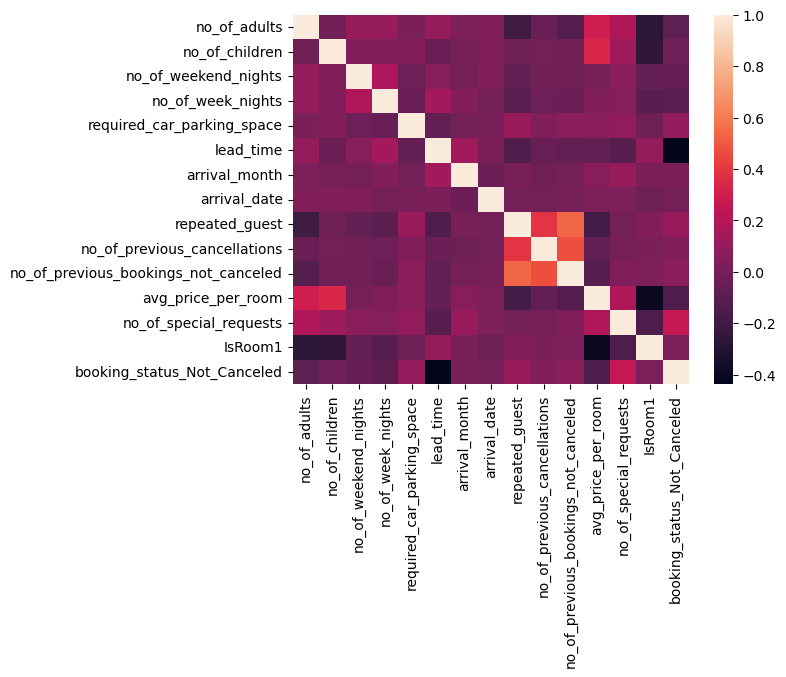

In [10]:
#checking for multicollinearity. probably i will remove 'repeated_guest'
corr= hotel_d.corr()
sns.heatmap(corr, )

• Check the histograms of the columns lead time, and no of previous bookings not canceled. If you
think there are outliers in the data, remove them.

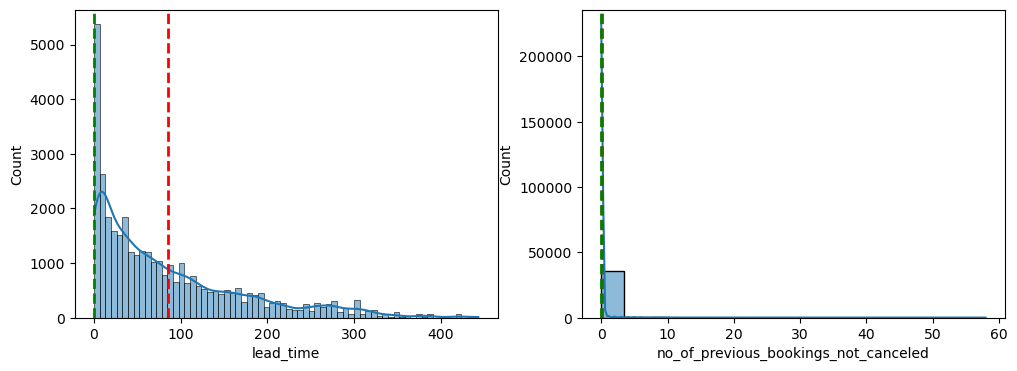

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(data=hotel_d, x='lead_time', kde=True, ax=ax[0])
ax[0].axvline(hotel_d['lead_time'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[0].axvline(hotel_d['lead_time'].mode()[0], color='g', linestyle='dashed', linewidth=2)

sns.histplot(data=hotel_d, x='no_of_previous_bookings_not_canceled',  kde=True, ax=ax[1])
ax[1].axvline(hotel_d['no_of_previous_bookings_not_canceled'].mean(), color='r', linestyle='dashed', linewidth=2)
ax[1].axvline(hotel_d['no_of_previous_bookings_not_canceled'].mode()[0], color='g', linestyle='dashed', linewidth=2)

<AxesSubplot:xlabel='no_of_previous_bookings_not_canceled'>

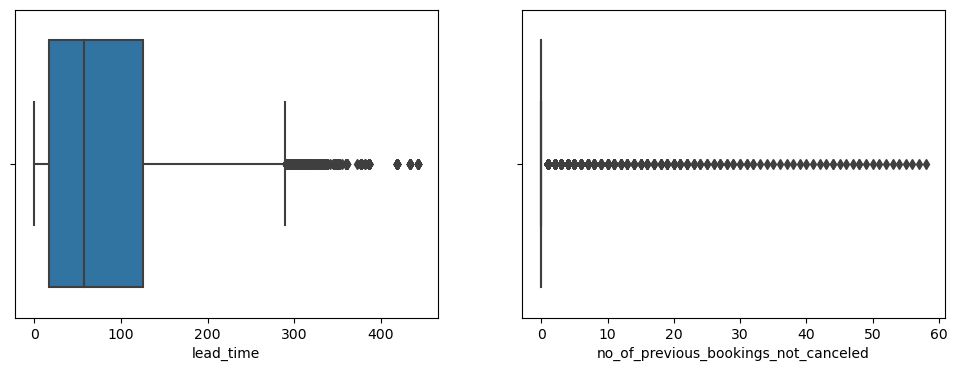

In [12]:
#finding outliers using a boxplot, which i prefere as a method

# for the variable nr of bookings not cancelled, it seems that basically 100% of the abservations
# are located around 0. everything else is just an outlier.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.boxplot(x='lead_time',data=hotel_d, ax=axs[0])
sns.boxplot(x='no_of_previous_bookings_not_canceled', data=hotel_d, ax=axs[1])

In [ ]:
#checking also all the other variables for a more complete overview

sns.boxplot( data = hotel_d, orient="h")

array([[<AxesSubplot:title={'center':'no_of_adults'}>,
        <AxesSubplot:title={'center':'no_of_children'}>,
        <AxesSubplot:title={'center':'no_of_weekend_nights'}>,
        <AxesSubplot:title={'center':'no_of_week_nights'}>],
       [<AxesSubplot:title={'center':'required_car_parking_space'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'arrival_month'}>,
        <AxesSubplot:title={'center':'arrival_date'}>],
       [<AxesSubplot:title={'center':'repeated_guest'}>,
        <AxesSubplot:title={'center':'no_of_previous_cancellations'}>,
        <AxesSubplot:title={'center':'no_of_previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'avg_price_per_room'}>],
       [<AxesSubplot:title={'center':'no_of_special_requests'}>,
        <AxesSubplot:title={'center':'IsRoom1'}>,
        <AxesSubplot:title={'center':'booking_status_Not_Canceled'}>,
        <AxesSubplot:>]], dtype=object)

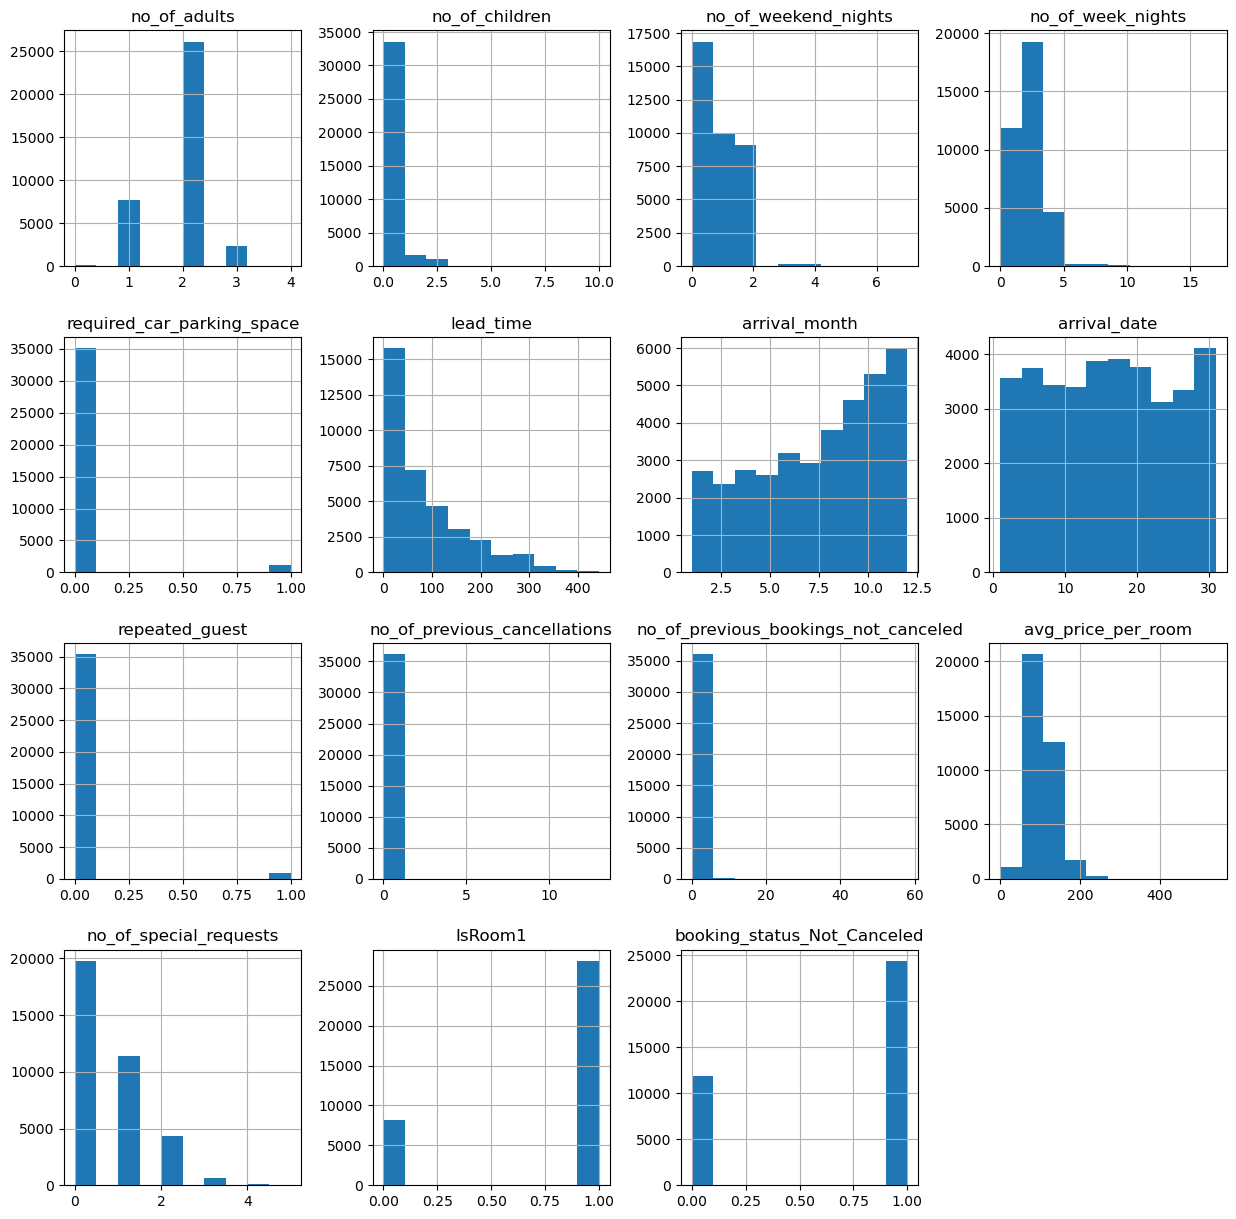

In [14]:
#using also a histogram so to have a better view on the amount of outliers

hotel_d.hist(figsize=(15, 15))


In [36]:
#proceeding with cleanup
#converting to binary some variables that have too little observations
hotel_d['HasChildren'] = (hotel_d['no_of_children'] != 0).astype(int)
hotel_d[['no_of_children','HasChildren']].value_counts()

no_of_children  HasChildren
0               0              33577
1               1               1618
2               1               1058
3               1                 19
9               1                  2
10              1                  1
dtype: int64

In [37]:
#trying to compact 2 columns that basically describe the same concept. Creating a new column
#that contains still useful information for my interested variable to predict, but reduces complexity
#for teh model

hotel_d['%of_confirmed_bookings'] = hotel_d['no_of_previous_bookings_not_canceled']/(hotel_d['no_of_previous_bookings_not_canceled']+hotel_d['no_of_previous_cancellations'])
hotel_d[['%of_confirmed_bookings','no_of_previous_bookings_not_canceled','no_of_previous_cancellations']].value_counts()
#hotel_d.info()
hotel_d['%of_confirmed_bookings'].fillna(0, inplace=True)

In [38]:
#dropping the original columns of what i cleaned, and also 'repeated guest' due to multicollinearity

hotel_c=hotel_d.drop(['no_of_children','no_of_previous_cancellations',
                      'no_of_previous_bookings_not_canceled',
                     'repeated_guest'],axis=1)
hotel_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   no_of_adults                 36275 non-null  int64  
 1   no_of_weekend_nights         36275 non-null  int64  
 2   no_of_week_nights            36275 non-null  int64  
 3   required_car_parking_space   36275 non-null  int64  
 4   lead_time                    36275 non-null  int64  
 5   arrival_month                36275 non-null  int64  
 6   arrival_date                 36275 non-null  int64  
 7   avg_price_per_room           36275 non-null  float64
 8   no_of_special_requests       36275 non-null  int64  
 9   IsRoom1                      36275 non-null  int64  
 10  booking_status_Not_Canceled  36275 non-null  uint8  
 11  HasChildren                  36275 non-null  int64  
 12  %of_confirmed_bookings       36275 non-null  float64
dtypes: float64(2), i

<AxesSubplot:>

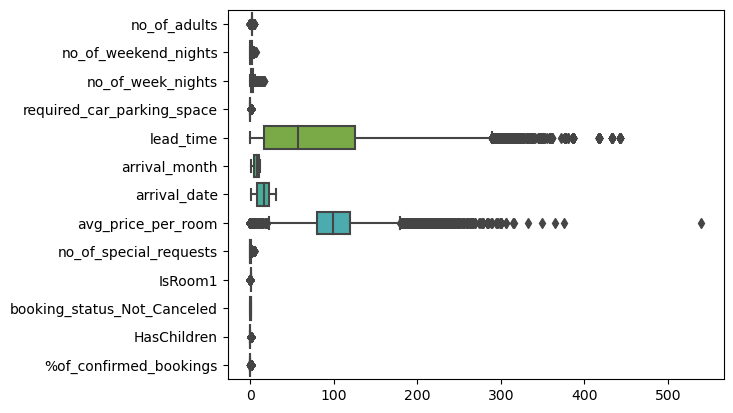

In [25]:
#checking outliers
sns.boxplot( data = hotel_c, orient="h")

(32031, 13)

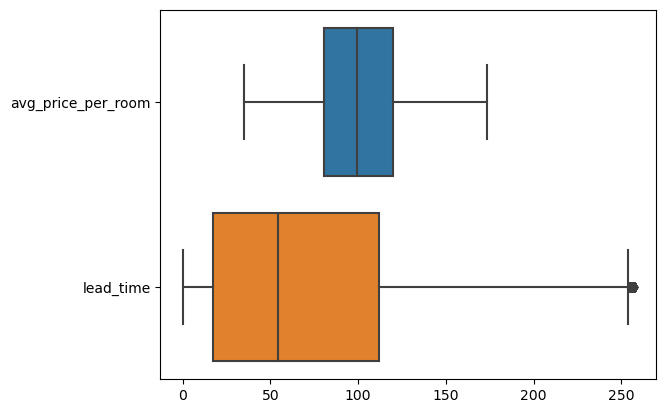

In [39]:
#claning outliers from room price and lead time

from scipy import stats

hotel_c = hotel_c[(np.abs(stats.zscore(hotel_d[['avg_price_per_room','lead_time']])) < 2).all(axis=1)]

sns.boxplot( data = hotel_c[['avg_price_per_room','lead_time']], orient="h")

hotel_c.shape

<AxesSubplot:>

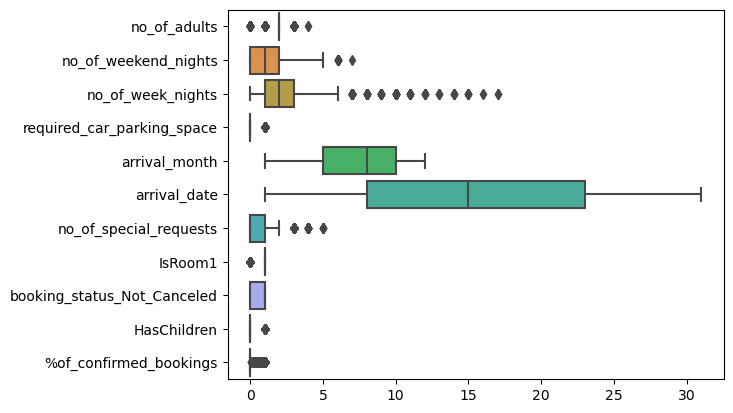

In [27]:
sns.boxplot( data = hotel_c.drop(['avg_price_per_room','lead_time'], axis=1), orient="h")

/tmp/ipykernel_10131/3433787164.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hotel_c = hotel_c[(np.abs(stats.zscore(hotel_d[['no_of_special_requests',


<AxesSubplot:>

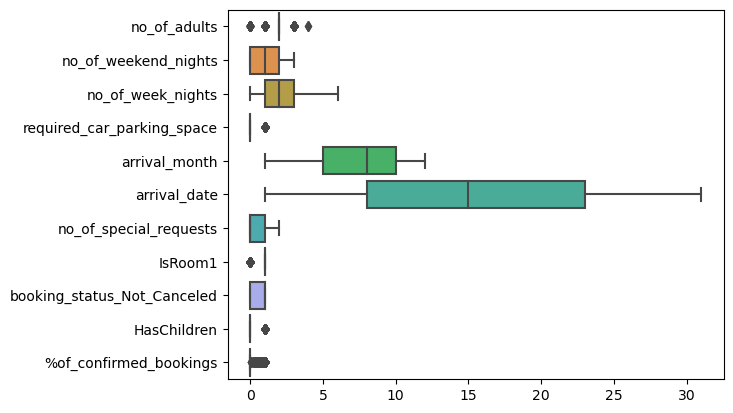

In [40]:
#cleaning also other outliers

hotel_c = hotel_c[(np.abs(stats.zscore(hotel_d[['no_of_special_requests',
                                                'no_of_week_nights',
                                               'no_of_weekend_nights']])) < 3).all(axis=1)]
sns.boxplot( data = hotel_c.drop(['avg_price_per_room','lead_time'], axis=1), orient="h")

In [41]:
#preparing to scale
from sklearn.preprocessing import MinMaxScaler

# Create a copy of the original DataFrame
hotel_s = hotel_c.copy()

scaler=MinMaxScaler()


columns_to_scale = ['lead_time','avg_price_per_room','arrival_month','arrival_date',
                    'no_of_week_nights','no_of_weekend_nights', 'no_of_adults', 'no_of_special_requests'
                   ,'%of_confirmed_bookings']

# apply the scaling to the selected columns
hotel_s[columns_to_scale] = scaler.fit_transform(hotel_s[columns_to_scale])
hotel_s

,no_of_adults,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_month,arrival_date,avg_price_per_room,no_of_special_requests,IsRoom1,booking_status_Not_Canceled,HasChildren,%of_confirmed_bookings
0,0.50,0.333333,0.333333,0,0.871595,0.818182,0.033333,0.216606,0.0,1,1,0,0.0
1,0.50,0.666667,0.500000,0,0.019455,0.909091,0.166667,0.517545,0.5,1,1,0,0.0
2,0.25,0.666667,0.166667,0,0.003891,0.090909,0.900000,0.180505,0.0,1,0,0,0.0
3,0.50,0.000000,0.333333,0,0.821012,0.363636,0.633333,0.469314,0.0,1,0,0,0.0
4,0.50,0.333333,0.166667,0,0.186770,0.272727,0.333333,0.429603,0.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,0.75,0.666667,1.000000,0,0.330739,0.636364,0.066667,0.958845,0.5,0,1,0,0.0
36271,0.50,0.333333,0.500000,0,0.887160,0.818182,0.533333,0.403971,1.0,1,0,0,0.0
36272,0.50,0.666667,1.000000,0,0.575875,0.545455,0.000000,0.457690,1.0,1,1,0,0.0
36273,0.50,0.000000,0.500000,0,0.245136,0.272727,0.666667,0.429603,0.0,1,0,0,0.0


<AxesSubplot:>

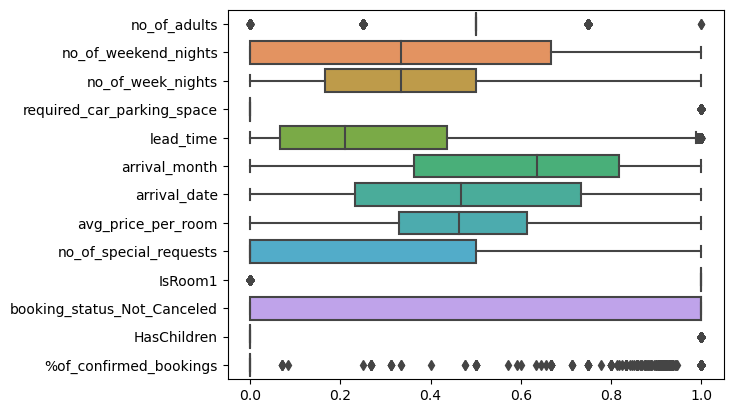

In [42]:
sns.boxplot( data = hotel_s, orient="h")

• Build a logistic regression classification model with ’booking status’ column as the target, and using
all other variables as predictors. Divide the data set into training (70 %) and test set (30 %), use
random state = 0, and follow the process of building a classification model as discussed in the course.

In [43]:
#ready for the regression model!

X = hotel_s.drop('booking_status_Not_Canceled', axis=1)
y =  hotel_s.booking_status_Not_Canceled

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=0)

model = LogisticRegression(solver = 'lbfgs',max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [44]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 11
                                Logit Regression Results                               
Dep. Variable:     booking_status_Not_Canceled   No. Observations:                21737
Model:                                   Logit   Df Residuals:                    21725
Method:                                    MLE   Df Model:                           11
Date:                         Sun, 26 Mar 2023   Pseudo R-squ.:                     inf
Time:                                 13:30:21   Log-Likelihood:                   -inf
converged:                                True   LL-Null:                        0.0000
Covariance Type:                     nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
no_of_ad

/home/marta/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/marta/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/marta/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/marta/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [46]:
y_predict = model.predict(X_test)
y_predict[:10]

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1], dtype=uint8)

• Create the confusion matrix, calculate classification performance measures. What is the accuracy of
the model on the test set?

In [47]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_predict)
print(matrix)

[[1335 1437]
 [ 600 5944]]


In [51]:
#by using our model to calculate the variable y, we obtain values that when compared with
#those from the y in test set match in 77% of the cases (true positives + true negatives
#divided by the total.

(1335+5944)/(1335+5944+600+1437)

0.7813439244310864

In [49]:
#this is confirmed also by teh accuracy paarmeter in the classification report

from sklearn.metrics import classification_report

report = classification_report(y_test, y_predict)

print(report)

              precision    recall  f1-score   support

           0       0.69      0.48      0.57      2772
           1       0.81      0.91      0.85      6544

    accuracy                           0.78      9316
   macro avg       0.75      0.69      0.71      9316
weighted avg       0.77      0.78      0.77      9316



• Does the model perform similarly for the two possible categories of the outcome column, i.e. for
hotel visits and cancelations? How many false positives do you find, i.e. guests who would visit the
hotel but the model predicts that they would cancel the booking?

In [ ]:
#according to the matrix above we got
#600 cases where the actual class ("booking not cancelled")was 0, but we predicted 1
#and 1437 cases where actual class was 1, but we predicted 0

#so basically we missed 1437 cases that should have been "bookings not cancelled" (these people could have booked our hotel!)
#and in 600 cases we predicted that the users would have booked teh hotel, but we were wrong (in case of e.g., advertisement, we would have targeted wrong in 600 cases)


## Task 3

10 points) In this exercise you have to work with the data in the file ’iris.csv’, that contains 150 records
of Iris flowers of three related species under 5 attributes - Petal Length, Petal Width, Sepal Length, Sepal
width and Class (Species). In the data there are three different species present, 50 samples each. You
have to perform clustering and assess whether clustering is able to distinguish the three different species.
Your task is to perform K-Means clustering on the dataset; in the model building process, do not use the
column ’species’. You need to perform the following steps:

• Determine the optimal number of clusters using the elbow method, and perform k-means clustering
with the chosen value (set random state = 0).

In [70]:
iris=pd.read_csv('Datasets/iris.csv')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [71]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [72]:
model_data = iris[['sepal_length', 'sepal_width','petal_length', 'petal_width' ]]
model_data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [73]:
data_scaled = model_data.apply(lambda x: preprocessing.scale(x))
data_scaled.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [74]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 5, random_state = 0)

kmeans.fit(data_scaled)

#sum of squared errors
print(kmeans.inertia_)

#locations of the centroids of clusters
print(kmeans.cluster_centers_)

# The number of iterations required to converge
print(kmeans.n_iter_)

140.96581663074699
[[-0.05021989 -0.88029181  0.34753171  0.28206327]
 [-1.01457897  0.84230679 -1.30487835 -1.25512862]
 [ 1.13597027  0.09659843  0.996271    1.01717187]]
5


In [75]:
#i am now iterating the model to run across scenarios with different clusters 
#in this case from 1 to 10

sse_clust = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(data_scaled)
    sse_clust.append(kmeans.inertia_)

sse_clust

[600.0000000000001,
 223.73200573676348,
 140.96581663074699,
 114.68221609937966,
 91.19197002146464,
 80.19300510158156,
 71.30070564118623,
 62.452683728324764,
 54.31087378179732,
 47.61654626377584]

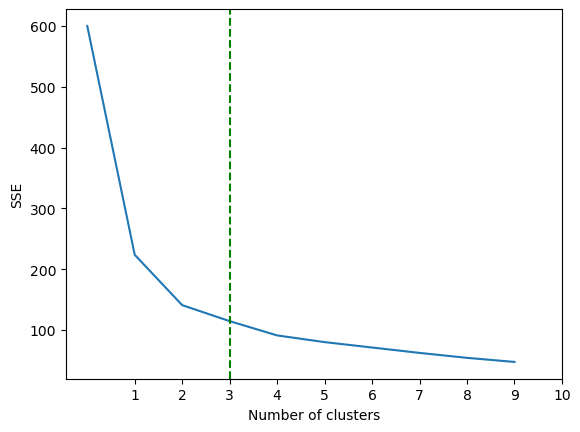

In [76]:
#let s look at how the inertia decreases along the different clusters used
#i have marked 3 since usially it is a good approximation, and that helps a bit to compare
#the decrease in inertia when going from cluster 2to3 and then from 3to4. It is not very remarkable 
#for the latter so i think we can choose k=3 for our model
plt.plot(sse_clust)
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.axvline(3, color= 'g', linestyle = 'dashed')
plt.show()

In [77]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)

y_clust = kmeans.fit_predict(data_scaled)

y_clust

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

• What is the average of each variable in each cluster (the original, not the scaled variables)?

In [78]:
#prefere to create a new df, will halp me with grouping later on belpw

iris_final=iris.assign(cluster = y_clust)
iris_final.groupby('cluster').mean()

,sepal_length,sepal_width,petal_length,petal_width
cluster,,,,
0,5.801887,2.673585,4.369811,1.413208
1,5.006000,3.418000,1.464000,0.244000
2,6.780851,3.095745,5.510638,1.972340


• Perform k-means clustering now with k=3 (if this was not your selected k value). When you compare
the resulting clusters with the original ’species’ column, you will find that one of the species is
perfectly identified by clustering (i.e., one of the three clusters contains all the datapoints belonging
to that species, and no datapoints from other species). Which one is the correctly identified species?
When you look at the mean value of the variables, can you identify which variable(s) ’confuse’ the
clustering model, i.e., which variables you think are responsible for the other two clusters being the
mix of the other two species

In [79]:
#now lets see how our model performed in classifying the species, by comparing it with the column
#that was actually containg the species name.
#Cluster 1 contains all the datapoints of Iris Setosa! Success!
#But datapoints of lenght and Withd of Sepal and Petal of one of the other 2 species have been
#"pulling" the center of the cluster away from the correct points and messing our model calcultaion

iris_final.groupby(['cluster','species']).count()

sepal_length  sepal_width  petal_length  petal_width
cluster species                                                              
0       Iris-versicolor            39           39            39           39
        Iris-virginica             14           14            14           14
1       Iris-setosa                50           50            50           50
2       Iris-versicolor            11           11            11           11
        Iris-virginica             36           36            36           36

In [80]:
#when looking at te mean of the variables and at the man of the variables per species,
# i think that maybe 'sepal width' could have contributed in cotegroizing wrongly the other 2 species
# because the mean of 2 species are quite close to eachother, so it would be difficlut to
#"tell them apart" based on the distance from the center: the mean of the variable is in fact 3.0
iris_final.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width,cluster
species,,,,,
Iris-setosa,5.006,3.418,1.464,0.244,1.00
Iris-versicolor,5.936,2.770,4.260,1.326,0.44
Iris-virginica,6.588,2.974,5.552,2.026,1.44


In [81]:
iris_final.mean()

/tmp/ipykernel_10131/1597283951.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  iris_final.mean()


sepal_length    5.843333
sepal_width     3.054000
petal_length    3.758667
petal_width     1.198667
cluster         0.960000
dtype: float64